In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.metrics import classification_report_imbalanced

# Read the CSV and Perform Basic Data Cleaning

In [4]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [5]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

## Convert categorical data to numeric
- From credit_risk_resampling notebook.

In [6]:
# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100

In [7]:
# Convert the target column values to low_risk and high_risk based on their values
df['loan_status'] = df['loan_status'].str.replace('Current', 'low_risk', regex=False)
df.loc[df['loan_status']!='low_risk', 'loan_status'] = 'high_risk'
df['loan_status'].value_counts();

In [8]:
# Drop columns with constant values: pymnt_plan, hardship_flag, debt_settlement_flag
df = df.drop(['pymnt_plan', 'hardship_flag', 'debt_settlement_flag'], axis=1)

In [9]:
# For columns with only 2 values, get dummies, dropping the first value
df = pd.get_dummies(df, columns=['initial_list_status', 'next_pymnt_d', 'application_type'], drop_first=True)

In [10]:
# For columns with more than 2 values, convert to numeric
df = pd.get_dummies(df, columns=['home_ownership', 'verification_status', 'issue_d'])

# Split the Data into Training and Testing

In [11]:
# Create our features
df.reset_index(drop=True, inplace=True)

X = df.copy()
X = X.drop('loan_status', axis=1)

# Create our target
y = df['loan_status']

# Get target labels
labels = y.unique()

In [12]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.009285,0.526309,0.106747,0.357659,0.478007,0.373992,0.148001,0.371696,0.451066,0.177238
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.095914,0.499311,0.308793,0.479314,0.499520,0.483865,0.355104,0.483261,0.497603,0.381873
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
# Check the balance of our target values
y_vc = y.value_counts()
print(f'Target counts : \n\thigh_risk - {y_vc["high_risk"]} \t({y_vc["high_risk"]/len(y):7.3%})')
print(f'\tlow_risk - {y_vc["low_risk"]} \t({y_vc["low_risk"]/len(y):7.3%})')
print(f'\tTotal - {len(y)}')

Target counts : 
	high_risk - 347 	( 0.504%)
	low_risk - 68470 	(99.496%)
	Total - 68817


In [14]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
X_train.shape

(51612, 89)

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [15]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
model = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
model.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=1)

In [16]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.7781282860147214

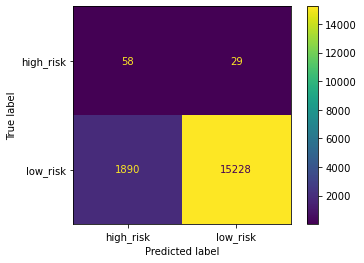

In [17]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot()

In [18]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.67      0.89      0.06      0.77      0.58        87
   low_risk       1.00      0.89      0.67      0.94      0.77      0.61     17118

avg / total       0.99      0.89      0.67      0.94      0.77      0.61     17205



In [19]:
# List the features sorted in descending order by feature importance
features_importance = sorted(zip(model.feature_importances_, model.feature_names_in_), reverse=True)
for fi, fn in features_importance:
    print(f'{fn:<36} : {fi:.3%}')

total_rec_prncp                      : 7.806%
total_rec_int                        : 5.940%
last_pymnt_amnt                      : 5.918%
total_pymnt_inv                      : 5.487%
total_pymnt                          : 5.458%
int_rate                             : 2.739%
mths_since_recent_inq                : 2.036%
dti                                  : 1.882%
mo_sin_old_rev_tl_op                 : 1.757%
bc_util                              : 1.743%
avg_cur_bal                          : 1.741%
installment                          : 1.727%
out_prncp_inv                        : 1.672%
il_util                              : 1.629%
annual_inc                           : 1.605%
issue_d_Jan-2019                     : 1.560%
out_prncp                            : 1.557%
bc_open_to_buy                       : 1.547%
max_bal_bc                           : 1.529%
total_rev_hi_lim                     : 1.431%
tot_cur_bal                          : 1.403%
total_bal_il                      

### Easy Ensemble AdaBoost Classifier

In [20]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier
model = EasyEnsembleClassifier(n_estimators=100, random_state=1)
model.fit(X_train, y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [21]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.9260991656292429

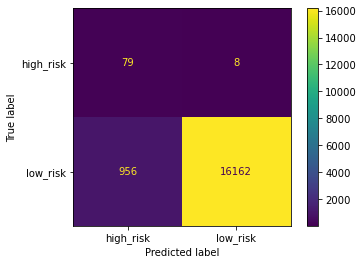

In [22]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot()

In [23]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.08      0.91      0.94      0.14      0.93      0.85        87
   low_risk       1.00      0.94      0.91      0.97      0.93      0.86     17118

avg / total       0.99      0.94      0.91      0.97      0.93      0.86     17205

